## Introducción a PyTorch (Parte 5)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Introducci%C3%B3n%20a%20PyTorch%20(Parte%205).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

En este notebook vamos a utilizar los conocimientos aprendidos en los notebooks anteriores para realizar un entrenamiento más avanzando. En particular aprenderemos lo siguiente:
- Carga de un dataset.
- Particionado de los datos.
- Creación de los DataLoaders.
- Bucle de entrenamiento, validación y early stopping.
- Salvar el modelo y checkpoints intermedios. Carga de modelos.
- Inferencia.

Trabajaremos en este caso con el conjunto FashionMNIST, un conjunto con **10 clases**, 60.000 ejemplos de entrenamiento y 10.000 ejemplos para test.

### Carga de los datos
Procederemos igual que en la práctica anterior:

In [1]:
import torch
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilizando dispositivo: %s" % device)

print("Datos de entrenamiento:")
print(training_data, end='\n\n')
print("Datos de test:")
print(test_data, end='\n\n')

# Separación de un conjunto de validación
training_data, validation_data = random_split(training_data,(50000,10000))

Utilizando dispositivo: %s cpu
Datos de entrenamiento:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Datos de test:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()



### Visualización de los datos

Visualizamos algunos datos para ver como son las imágenes:

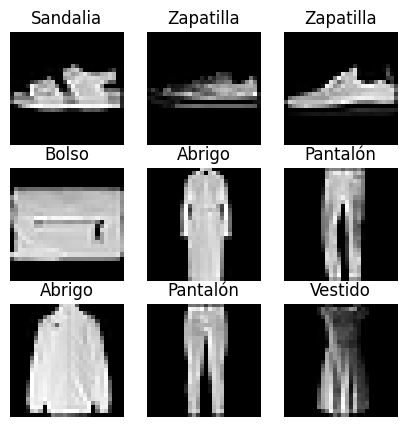

In [2]:
labels_map = {
    0: "Camiseta",
    1: "Pantalón",
    2: "Jersey",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota",
}

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creación de los DataLoaders

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

### Definición de la red
En este caso utilizaremos de nuevo una red totalmente conectada, aunque sería más adecuado utilizar una red convolucional para mejorar el rendimiento del sistema.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, dropout=0.2, linear_sizes = (50, 50, 10)):
        super(Net, self).__init__()
        self.layers = nn.Sequential()
        previous_size = 28*28 # la entrada tienen que coincidir con el número de pixeles en la imagen
        for i, linear_size in enumerate(linear_sizes):
            self.layers.append(nn.Linear(previous_size, linear_size))
            if i != len(linear_sizes):
                # Añadir dropout salvo en la última capa de salida
                self.layers.append(nn.Dropout(dropout))
            previous_size = linear_size

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layers(x)

### Creación de los bucles de validación y entrenamiento
Aquí vamos a crear los bucles de entrenamiento de la red. En primer lugar creamos el bucle de validación, que se encarga de calcular la función de pérdida en el conjunto de validación. Ten en cuenta que en este caso no necesitamos actualizar los gradientes de la red, por tanto utilizamos `torch.no_grad()` y ponemos la red en modo evaluación con el método `eval()`.

In [5]:
def validation(model, loss_module, val_dataloader):
    val_loss=0
    with torch.no_grad():
        model.eval()
        for data_inputs, data_labels in val_dataloader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            logits = model(data_inputs)
            val_loss += loss_module(logits, data_labels)
        return val_loss/ len(val_dataloader)


En el bucle de entrenamiento, después de acabar cada época, calculamos el error de validación y lo imprimimos. Este error también se usa para realizar la **parada temprana**, cuando el error de validación deje de decrecer. También aprovechamos para salvar el mejor modelo hasta el momento. Para ello utilizamos la instrucción: `torch.save(model.state_dict(), 'best_model.pth')`. 

In [6]:
from tqdm.notebook import tqdm

def train_model(model, optimizer, train_dataloader, val_dataloader, loss_module, patience=3, max_epochs=50):
    # Set model to train mode
    model.train()
    min_loss = float('inf')
    no_improvement = 0

    # Training loop
    pbar = tqdm(range(max_epochs))
    for epoch in pbar:
        epoch_loss = 0
        for data_inputs, data_labels in train_dataloader:
            #Hacer una pasada hacia delante
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]
            #Calcular el valor de la función de pérdida para este mini-batch
            loss = loss_module(preds, data_labels)
            #Acumular el error (solo para luego mostrarlo)
            epoch_loss += loss.item()
            #Reiniciar los gradientes
            optimizer.zero_grad()
            #Pasada hacia atrás
            loss.backward()
            #Actualizar los parámetros
            optimizer.step()
        val_loss = validation(model, loss_module, val_dataloader)
        if val_loss < min_loss:
            min_loss = val_loss
            no_improvement=0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement += 1

        pbar.set_description("Training Loss %0.2f. Validation Loss %0.2f. Patience: %d/%d" % (epoch_loss/len(train_dataloader), val_loss, no_improvement, patience))
        if no_improvement>=patience:
            print("No hay mejora por %d épocas. Parada Temprana!!" % patience)
            break



### Entrenando la red
Una vez que tenemos todo preparado estamos en situación de entrenar la red. Para ello inicializamos el modelo y lanzamos el entrenamiento. Hay que tener en cuenta que el mejor modelo quedará salvado en el archivo `best_model.pth`, que luego podremos utilizar para inferencia.

In [7]:
model = Net(dropout=0.2, linear_sizes=(50,10))
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss = nn.CrossEntropyLoss()
train_model(model, optimizer, train_dataloader, val_dataloader, loss)

  0%|          | 0/50 [00:00<?, ?it/s]

No hay mejora por 3 épocas. Parada Temprana!!


### Inferencia
Una vez que tenemos entrenado el modelo es momento de evaluar el conjunto de test con él y analizar las métricas que estemos interesados.

In [8]:
# Cargamos el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    model.eval()
    for data_inputs, data_labels in test_dataloader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        logits = model(data_inputs)
        _, predicted_classes = torch.max(logits, 1)  # Get the predicted classes
        correct_predictions += (predicted_classes == data_labels).sum().item()
        total_predictions += data_labels.size(0)
    accuracy = correct_predictions / total_predictions
    print("Accuracy: {:.2%}".format(accuracy))
    

Accuracy: 83.11%


### Ejercicios
1. Modifica el código para que tanto en el entrenamiento como en validación se calcule (y se imprima en la barra de progreso) también el acierto del modelo y no solo el cross entropy.
2. Modifica los hiperparámetros del entrenamiento. ¿Hasta donde eres capaz de llevar el acierto en test?
3. Modifica el código para salvar en cada época la loss de entrenamiento y de validación y al final del entrenamiento, pinta una gráfica para ver como han progresado ambas métricas.